In [1]:
import os
import io
import gpxpy
import folium
import selenium
import requests
import numpy as np
import pandas as pd
import sqlite3 as sq
import seaborn as sb
import osmnx as ox
import matplotlib.pyplot as plt


from PIL import Image
from scipy.stats import normaltest, shapiro, kstest, f_oneway
from geopy.distance import geodesic
from ipywidgets import IntProgress
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [2]:
def parse_gpx(gpx_string, track_id):
    """
    Парсинг gpx строки в список словарей содержащих все данные о точке
    """
    try:
        gpx = gpxpy.parse(gpx_string)
    except Exception as e:
        print(e)
        return None
    points = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                points.append({
                            'track_id': track_id,
                            'latitude': point.latitude,
                            'longitude': point.longitude,
                            'elevation': point.elevation,
                            'time': point.time,
                            'name': track.name
                        })
    return points

In [3]:
def length(parsed_gpx):
    """
    расчёт расстояний между соседними точками используя geopy
    """
    length_3d = []
    for track in parsed_gpx.groupby('track_id'):
        track = track[1].sort_values('time')
        for idx in track.index[:-1]:
            p1 = (track['latitude'][idx], track['longitude'][idx])
            p2 = (track['latitude'][idx + 1], track['longitude'][idx + 1])
            length_2d = geodesic(p1, p2).meters
            if pd.notna(track['elevation'][idx]):
                length_track = np.sqrt((length_2d ** 2) + (track['elevation'][idx] - track['elevation'][idx + 1]) ** 2)
            else:
                length_track = length_2d
            length_3d.append(length_track)
        length_3d.append(None)
    return length_3d

In [4]:
def time_delta(parsed_gpx):
    """
    Расчёт времени между соседними точками
    """
    time_delta = []
    for track in parsed_gpx.groupby('track_id'):
        track = track[1].sort_values('time')
        for idx in track.index[:-1]:
            time_delta.append(track['time'][idx + 1] - track['time'][idx])
        time_delta.append(None)
    return time_delta

In [5]:
def mean_day_temp(lat, lon, time):
    """
    Шаблон Get запроса к open-meteo для получения температуры в указанный день
    """
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
    	"latitude": lat,
    	"longitude": lon,
    	"start_date": time,
    	"end_date": time,
    	"daily": "temperature_2m_mean",
    }
    response = requests.get(url, params=params)
    return response.json()['daily']['temperature_2m_mean']

In [6]:
def temp_per_track(parsed_gpx):
    """
    Расчёт среддней температуры для каждого трека
    """
    temp = []
    bar = IntProgress(min=0, max=len(parsed_gpx['track_id'].unique()))
    display(bar)
    for track in parsed_gpx.groupby('track_id'):
        track = track[1]
        if pd.notna(track['time']).sum():
            id = track.index[0]
            test = mean_day_temp(track['latitude'][id], track['longitude'][id], str(track['time'][id])[:10])
            temp.append(test[0])
        else:
            temp.append(None)
        bar.value += 1
    return temp

In [7]:
def parse_features(lat, lon, radius=500):
    """
    Подсчёт количества обьектов на заданном расстояние от точки с использованием osmnx
    """
    point = (lat, lon)
    tags = {
        "water": {"natural": "water"},
        "forest": {"natural": "wood"},
        "buildings": {"building": True}
    }
    
    features = {}
    for key, tag in tags.items():
        try:
            gdf = ox.features.features_from_point(point, dist=radius, tags=tag)
            features[key] = len(gdf)
        except Exception as e:
            features[key] = 0
    
    return features

In [8]:
def get_features(parsed_gpx, n=3):
    """
    Получение информации о количестве обьектов вокруг каждой n точки (с целью оптимизации)
    """
    bar = IntProgress(min=0, max=len(parsed_gpx.index))
    display(bar)
    water = []
    forest = []
    buildings = []
    features = parse_features(parsed_gpx['latitude'][0], parsed_gpx['longitude'][0])
    for idx in parsed_gpx.index:
        if idx % n == 0:
            features = parse_features(parsed_gpx['latitude'][idx], parsed_gpx['longitude'][idx])
        water.append(features['water'])
        forest.append(features['forest'])
        buildings.append(features['buildings'])
        bar.value += 1
    return water, forest, buildings

In [9]:
def around_type(df):
    """
    Определение типа местности на основе информации о количестве обьектов вокруг точки
    """
    if pd.notna(df[['water', 'forest', 'buildings']]).sum() and df[['water', 'forest', 'buildings' ]].sum():
        if df['water'] + df['forest'] > 0:
            around = {'water': df['water'], 'forest': df['forest']}
            return max(around, key=around.get)
        if df['buildings'] > 0:
            return 'city'
    return None

In [10]:
class Agent:
    def __init__(self, path_to_db:str, path_to_maps:str):
        """
        Определяем пути и настройки
        """
        self.path_to_db = path_to_db
        self.path_to_maps = path_to_maps
        ox.settings.use_cache=True

    def save_data(self):
        """
        Сохранение данных в базу данных
        """
        try:
            conn = sq.connect(self.path_to_db)
            self.data.to_sql("data", con=conn, if_exists="replace", index=False)
            conn.close()
        except Exception as e:
            print(e)

    def parse_paths(self, paths:list[str]):
        """
        парсим файлы по списку путей
        """
        # загружаем gpx файлы и создаём датафрейм
        all_points = []
        trace_id = []
        self.idx = 0
        for path in paths:
            gpx = open(path, 'r')
            parsed_gpx = parse_gpx(gpx, self.idx)
            if parsed_gpx:
                all_points.extend(parsed_gpx)
                self.idx += 1
        parsed_gpx = pd.DataFrame(all_points)
        print(f"Создан dataframe с {len(parsed_gpx['track_id'].unique())} маршрутами")
        self.data = parsed_gpx

    def add_gpx(self, gpx_strings:list[str]):
        """
        Добавляем данные из gpx строк
        """
        all_points = []
        for gpx in gpx_strings:
            parsed_gpx = parse_gpx(gpx, self.idx)
            if parsed_gpx:
                all_points.extend(parsed_gpx)
                self.idx += 1
        parsed_gpx = pd.DataFrame(all_points)
        print(f"В датасет добавлены {len(parsed_gpx['track_id'].unique())} маршрутов")
        self.data = pd.concat([self.data, parsed_gpx], ignore_index=True)

    def fill_dataset(self):
        """
        Дополняем данные получившегося датасета используя функции выше
        """
        parsed_gpx = self.data
        
        # Просчитываем расстояния между точками
        length_3d = length(parsed_gpx)
        parsed_gpx['length_3d'] = length_3d
        print("Посчитанны расстояния между точками")
    
        # Расчитываем время между точками
        parsed_gpx['time_delta'] = time_delta(parsed_gpx)
        print("Просчитано время между точками")
    
        # Просчитываем частоту шагов
        parsed_gpx['step_frequency'] = parsed_gpx.apply(lambda parsed_gpx: (parsed_gpx['length_3d'] / 0.75) / parsed_gpx['time_delta'].total_seconds(), axis=1)
        print("Просчитана частота шагов")
    
        print('Просчитываем температуру для каждого трека')
        temp = temp_per_track(parsed_gpx)
        parsed_gpx['tempurture'] = parsed_gpx['track_id'].map(lambda x: temp[x])
        print("Просчитана температура для каждого трека")

        n=12
        print(f'Парсим обьекты вокруг каждой {n} точки и определяем тип местности')
        water, forest, buildings = get_features(parsed_gpx, n=n)
        parsed_gpx['water'] = water + [None] * (len(parsed_gpx) - len(water))
        parsed_gpx['forest'] = forest + [None] * (len(parsed_gpx) - len(forest))
        parsed_gpx['buildings'] = buildings + [None] * (len(parsed_gpx) - len(buildings))
        parsed_gpx['type'] = parsed_gpx.apply(around_type, axis=1)
        
        self.data = parsed_gpx

    def gen_img(self):
        for track in self.data.groupby('track_id'):
            track = track[1]
            idx = round(track['track_id'].mean())
            m = folium.Map(location=[track['latitude'].mean(), track['longitude'].mean()], zoom_start=14)
            folium.PolyLine(track[['latitude', 'longitude']].values, tooltip="Coast").add_to(m)
            print(f"Карта маршрута {idx}")
            display(m)
            img_data = m._to_png(5)
            img = Image.open(io.BytesIO(img_data))
            img.save(os.path.join(self.path_to_maps, f'{idx}.png'))
        

In [11]:
agent = Agent("data.db", "Maps/")
agent.parse_paths(['datasets/1.gpx', 'datasets/2.gpx'])

Создан dataframe с 2 маршрутами


In [12]:
gpx_data = pd.read_csv("datasets/gpx-tracks-from-hikr.org.csv")

In [13]:
agent.add_gpx(list(gpx_data['gpx'][:5]))

В датасет добавлены 5 маршрутов


In [14]:
agent.fill_dataset()

Посчитанны расстояния между точками
Просчитано время между точками
Просчитана частота шагов
Просчитываем температуру для каждого трека


IntProgress(value=0, max=7)

Просчитана температура для каждого трека
Парсим обьекты вокруг каждой 12 точки и определяем тип местности


IntProgress(value=0, max=1241)

In [15]:
agent.gen_img()

Карта маршрута 0


Карта маршрута 1


Карта маршрута 2


Карта маршрута 3


Карта маршрута 4


Карта маршрута 5


Карта маршрута 6


In [16]:
agent.save_data()

C:\Users\demoexam\AppData\Local\Temp\ipykernel_8084\874071278.py:16: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  self.data.to_sql("data", con=conn, if_exists="replace", index=False)


In [17]:
agent.data.describe()

,track_id,latitude,longitude,elevation,length_3d,time_delta,step_frequency,tempurture,water,forest,buildings
count,1241.000000,1241.000000,1241.000000,1241.000000,1234.000000,1234,1234.000000,1241.000000,1241.000000,1241.000000,1241.000000
mean,3.525383,46.908378,10.436739,1178.706978,92.290626,0 days 00:02:04.938411669,1.197310,12.711281,0.911362,0.642224,121.188558
std,1.868122,0.393205,2.244832,614.801957,129.852001,0 days 00:02:24.469966512,0.678800,2.883393,1.183982,1.484638,227.523405
min,0.000000,46.179897,8.278574,176.540000,10.454730,0 days 00:00:02,0.044963,8.900000,0.000000,0.000000,0.000000
25%,2.000000,46.954467,8.427124,513.000000,42.189204,0 days 00:00:55,0.752271,10.400000,0.000000,0.000000,3.000000
50%,4.000000,46.995192,8.982132,1299.840000,73.663735,0 days 00:01:33,1.197177,13.300000,1.000000,0.000000,20.000000
75%,5.000000,47.224808,13.165081,1764.170000,118.808206,0 days 00:02:28,1.639482,13.600000,1.000000,1.000000,110.000000
max,6.000000,47.262924,13.242523,2265.000000,3913.937648,0 days 00:40:19,14.467110,17.000000,7.000000,10.000000,1180.000000


In [18]:
agent.data.isnull().sum()

track_id            0
latitude            0
longitude           0
elevation           0
time                0
name                0
length_3d           7
time_delta          7
step_frequency      7
tempurture          0
water               0
forest              0
buildings           0
type              108
dtype: int64

In [19]:
agent.data['track_id'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [20]:
agent.data

,track_id,latitude,longitude,elevation,time,name,length_3d,time_delta,step_frequency,tempurture,water,forest,buildings,type
0,0,47.231143,13.227007,1322.96,2018-05-11 07:37:40+00:00,remsteinkopf,76.415020,0 days 00:02:04,0.821667,10.4,0,0,36,city
1,0,47.230543,13.227488,1330.89,2018-05-11 07:39:44+00:00,remsteinkopf,76.007919,0 days 00:01:33,1.089719,10.4,0,0,36,city
2,0,47.230637,13.226510,1344.41,2018-05-11 07:41:17+00:00,remsteinkopf,74.479614,0 days 00:01:19,1.257040,10.4,0,0,36,city
3,0,47.231071,13.225765,1350.43,2018-05-11 07:42:36+00:00,remsteinkopf,25.522352,0 days 00:00:22,1.546809,10.4,0,0,36,city
4,0,47.231073,13.225428,1350.18,2018-05-11 07:42:58+00:00,remsteinkopf,51.406322,0 days 00:00:51,1.343956,10.4,0,0,36,city
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,6,46.999420,8.610561,451.00,2018-05-11 12:49:26+00:00,2018-05-11 15:01:50,14.085215,0 days 00:00:26,0.722319,13.6,3,1,751,water
1237,6,46.999476,8.610403,447.15,2018-05-11 12:49:52+00:00,2018-05-11 15:01:50,17.309920,0 days 00:00:43,0.536742,13.6,3,1,751,water
1238,6,46.999367,8.610560,450.52,2018-05-11 12:50:35+00:00,2018-05-11 15:01:50,34.176454,0 days 00:02:46,0.274510,13.6,3,1,751,water
1239,6,46.999580,8.610884,450.03,2018-05-11 12:53:21+00:00,2018-05-11 15:01:50,18.564216,0 days 00:01:04,0.386755,13.6,3,1,751,water


In [21]:
describtions = pd.read_csv("describtions.csv")
describtions

,Название,Перевод,Описание,Тип данных,Система счисления,Unnamed: 5
0,latitude,высота,GPS высота точки,float,Градусы,NaN
1,longitude,широта,GPS широта точки,float,Градусы,NaN
2,elevation,высота над уровнем моря,высота точки над уровнем моря,float,метры,NaN
3,time,время,время регистрации точки,TimeDate,-,NaN
4,name,имя,имя маршрута,str,-,NaN
5,length_3d,длина трёхмерная,расстояние между точками с учётом высоты,float,метры,NaN
6,time_delta,разница времени,время прохождения между двумя точками,TimeDelta,-,NaN
7,step_frequency,частота шагов,частота шагов,float,Гц,NaN
8,tempurture,температура,температура воздуха на момент прохождения,float,Градусы,NaN
9,water,вода,кол-во водоёмов,int,-,NaN


# Статистика

## length_3d

<Axes: xlabel='length_3d', ylabel='Count'>

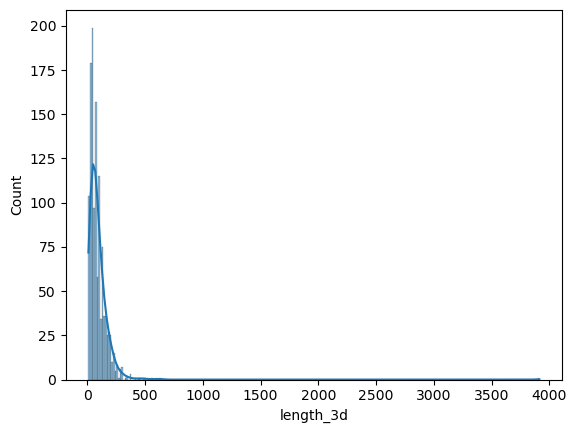

In [22]:
sb.histplot(agent.data['length_3d'], kde=True)

In [23]:
res = normaltest(agent.data['length_3d'])
print(res.statistic)
print(res.pvalue)

nan
nan


In [24]:
res = shapiro(agent.data['length_3d'])
print(res.statistic)
print(res.pvalue)

nan
nan


In [25]:
res = kstest(agent.data['length_3d'], 'expon')
print(res.statistic)
print(res.pvalue)

nan
nan


## time_delta

<Axes: xlabel='time_delta', ylabel='Count'>

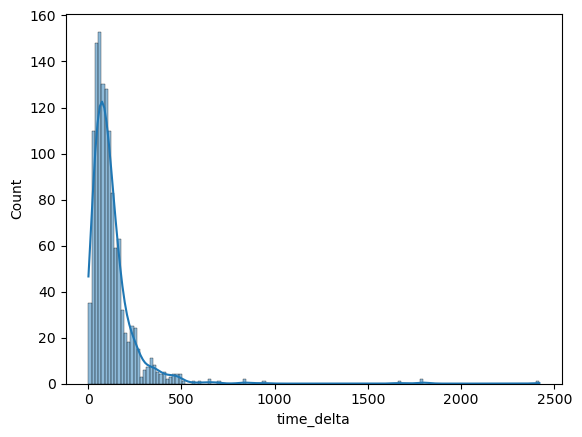

In [26]:
sb.histplot(agent.data['time_delta'].map(lambda x: x.seconds), kde=True)

In [27]:
res = normaltest(agent.data['time_delta'].map(lambda x: x.seconds))
print(res.statistic)
print(res.pvalue)

nan
nan


In [28]:
res = shapiro(agent.data['time_delta'].map(lambda x: x.seconds))
print(res.statistic)
print(res.pvalue)

nan
nan


In [29]:
res = kstest(agent.data['time_delta'].map(lambda x: x.seconds), "expon")
print(res.statistic)
print(res.pvalue)

nan
nan


## tempurture

<Axes: xlabel='tempurture', ylabel='Count'>

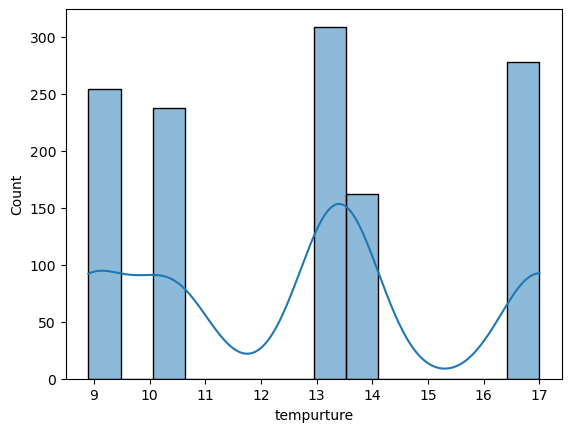

In [30]:
sb.histplot(agent.data['tempurture'], kde=True)

In [31]:
res = normaltest(agent.data['tempurture'])
print(res.statistic)
print(res.pvalue)

912.2483099279101
8.087167465278826e-199


In [32]:
res = shapiro(agent.data['tempurture'])
print(res.statistic)
print(res.pvalue)

0.8595689025918039
7.0093134513056e-32


## step_frequency

<Axes: xlabel='step_frequency', ylabel='Count'>

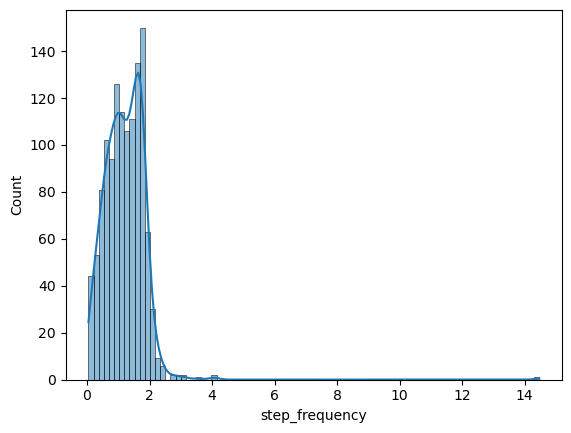

In [33]:
sb.histplot(agent.data['step_frequency'], kde=True)

In [34]:
res = normaltest(agent.data['step_frequency'])
print(res.statistic)
print(res.pvalue)

nan
nan


In [35]:
res = normaltest(agent.data['step_frequency'])
print(res.statistic)
print(res.pvalue)

nan
nan


In [36]:
res = kstest(agent.data['step_frequency'], "expon")
print(res.statistic)
print(res.pvalue)

nan
nan


## type

<Axes: xlabel='type', ylabel='Count'>

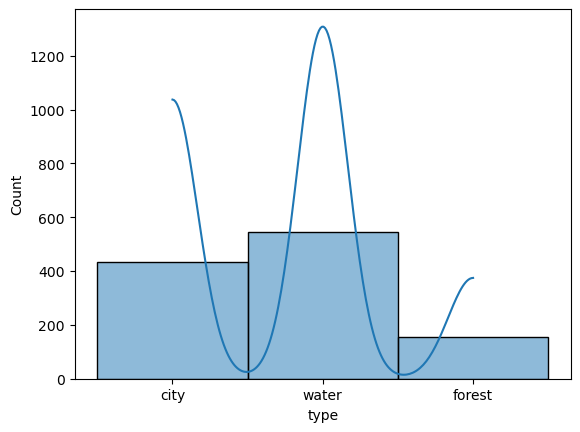

In [37]:
sb.histplot(agent.data['type'], kde=True)

Создание числового датасета

In [38]:
clean = agent.data.dropna()
clean = clean.drop(['name'], axis=1)
clean["type"] = clean["type"].map({'city': 0, 'water': 1, 'forest': 2})
clean['time_delta'] = clean['time_delta'].map(lambda x: x.seconds)
clean['time'] = clean['time'].map(lambda x: x.timestamp())

In [39]:
clean

,track_id,latitude,longitude,elevation,time,length_3d,time_delta,step_frequency,tempurture,water,forest,buildings,type
0,0,47.231143,13.227007,1322.96,1.526024e+09,76.415020,124,0.821667,10.4,0,0,36,0
1,0,47.230543,13.227488,1330.89,1.526024e+09,76.007919,93,1.089719,10.4,0,0,36,0
2,0,47.230637,13.226510,1344.41,1.526024e+09,74.479614,79,1.257040,10.4,0,0,36,0
3,0,47.231071,13.225765,1350.43,1.526025e+09,25.522352,22,1.546809,10.4,0,0,36,0
4,0,47.231073,13.225428,1350.18,1.526025e+09,51.406322,51,1.343956,10.4,0,0,36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,6,46.999248,8.610413,449.55,1.526043e+09,22.246137,16,1.853845,13.6,3,0,742,1
1236,6,46.999420,8.610561,451.00,1.526043e+09,14.085215,26,0.722319,13.6,3,1,751,1
1237,6,46.999476,8.610403,447.15,1.526043e+09,17.309920,43,0.536742,13.6,3,1,751,1
1238,6,46.999367,8.610560,450.52,1.526043e+09,34.176454,166,0.274510,13.6,3,1,751,1


In [40]:
res = normaltest(clean['type'])
print(res.statistic)
print(res.pvalue)

135.06281460619817
4.6933447130870616e-30


In [41]:
res = shapiro(clean['type'])
print(res.statistic)
print(res.pvalue)

0.7865907460375602
5.611838456846761e-36


# Анализ значимых атрибутов

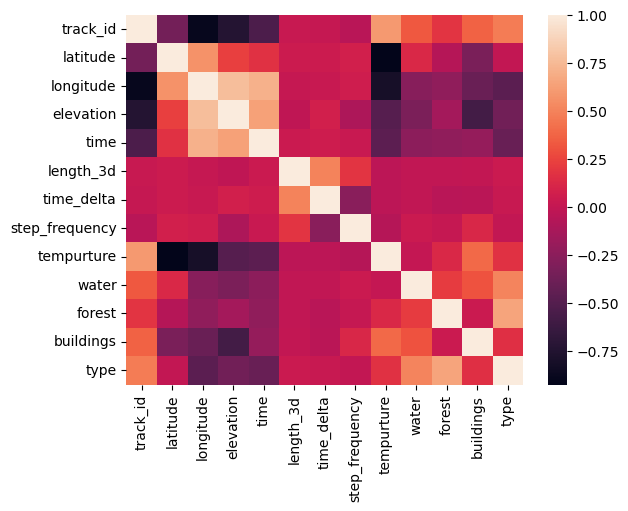

In [42]:
cor = clean.corr()
sb.heatmap(cor)
plt.show()

In [43]:
groups = [group['type'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

112.92147291651571 2.0746483530872718e-111


In [44]:
groups = [group['latitude'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

184937.64530385428 0.0


In [45]:
groups = [group['longitude'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

798887.7923495243 0.0


In [46]:
groups = [group['time'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

8842.000249860976 0.0


In [47]:
groups = [group['length_3d'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

2.0853700930660053 0.05236393651985808


In [48]:
groups = [group['elevation'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

406.26476634109474 7.701524706674755e-277


In [49]:
groups = [group['forest'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

29.1654160786074 1.4574509469607766e-32


### Анализ атрибутов показал, что признаки ('type', 'latitude', 'longitude', 'time', 'length_3d', 'elevation', 'forest') в датасете сильно влияют на схожесть групп

## Проводим кластеризацию используя значимые атрибуты

C:\Users\demoexam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\demoexam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


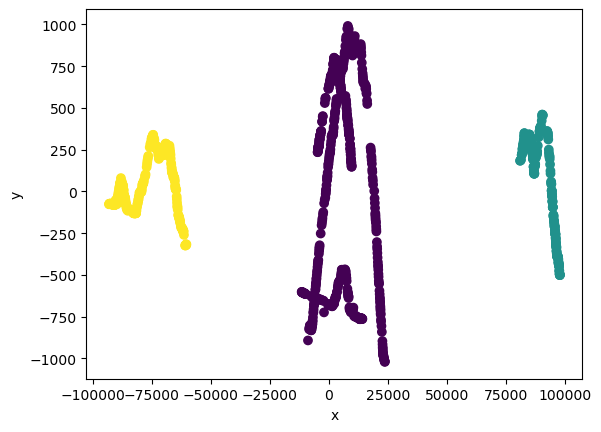

In [50]:
pca = PCA(n_components=2)
class_data = clean[['type', 'latitude', 'longitude', 'time', 'length_3d', 'elevation', 'forest']]
data_2d = pca.fit_transform(class_data)
dbscan = KMeans(n_clusters=3)
dbscan.fit(data_2d)
labels = dbscan.fit_predict(class_data)
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [51]:
labels = pd.Series(labels)
labels.name = "cluster"
clean = pd.concat([clean, labels], axis=1)

In [52]:
try:
    conn = sq.connect("data.db")
    clean.to_sql("clean", con=conn, if_exists="replace", index=False)
    conn.close()
except Exception as e:
    print(e)